# WMT of $G_\Omega(\theta)$ and $\frac{d}{dt}M_\Omega(\theta)$
> where $\Omega$ is the surface boundary of the WWM of the MHW event in $\theta$ space

> surface terms come from ERA5/MERRA2 and `dMdt` term comes from Glorys

> [(MERRA Summary page link)](https://disc.gsfc.nasa.gov/datasets/M2T1NXOCN_5.12.4/summary) Note: This product is the only one from this database that has all four variables in one. The other products might have most of the necessary data vars except for sensible heat flux from ocean.

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import pandas as pd

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

era23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))
merra23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2023.zarr'))

era1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/surf_ds_2010_22.zarr'))
merra_1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2010_2022.zarr'))

In [3]:
era_hrly = xr.concat([era1022, era23], dim='time')
merra_hrly = xr.concat([merra_1022, merra23], dim='time')

In [4]:
era_hrly

<xarray.Dataset> Size: 23GB
Dimensions:    (latitude: 41, longitude: 113, time: 122712)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 982kB 2010-01-01 ... 2023-12-31T23:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
    str        (time, latitude, longitude) float64 5GB dask.array<chunksize=(2374, 41, 113), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
merra_hrly

<xarray.Dataset> Size: 2GB
Dimensions:   (lat: 21, lon: 46, time: 122712)
Coordinates:
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 368B -100.0 -99.38 -98.75 ... -73.12 -72.5 -71.88
  * time      (time) datetime64[ns] 982kB 2010-01-01T00:30:00 ... 2023-12-31T...
Data variables:
    EFLUXWTR  (time, lat, lon) float32 474MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 474MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 474MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 474MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 474MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

In [6]:
## convert from J/m^2 -> W/m^2
era_wm2 = era_hrly / (60*60)
#resample to daily freq (hourly too noisy
era_daily = era_wm2.sel(longitude=slice(-100, -80)).resample(time='D').mean('time')
merra_daily = merra_hrly.sel(lon=slice(-100, -80)).resample(time='D').mean('time')
merra_daily['EFLUXWTR'] = (-merra_daily.EFLUXWTR)
merra_daily['HFLUXWTR'] = (-merra_daily.HFLUXWTR)

In [7]:
sst_era = (era_hrly.sst-273.15).resample(time='D').mean()
sst_era_sliced = sst_era.sel(longitude=slice(-100, -80))
sst_merra = (merra_daily.TSKINWTR-273.15)

era_unsorted = xr.merge([era_daily.drop_vars('sst'), sst_era_sliced])
era = era_unsorted.sortby('latitude')
merra = xr.merge([merra_daily.drop_vars('TSKINWTR'), sst_merra])

In [8]:
era.load()

<xarray.Dataset> Size: 679MB
Dimensions:    (time: 5113, latitude: 41, longitude: 81)
Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31
Data variables:
    slhf       (time, latitude, longitude) float64 136MB -14.05 ... -380.4
    sshf       (time, latitude, longitude) float64 136MB -41.33 ... -123.3
    ssr        (time, latitude, longitude) float64 136MB 69.84 68.71 ... 145.2
    str        (time, latitude, longitude) float64 136MB -40.41 ... -140.9
    sst        (time, latitude, longitude) float64 136MB nan nan ... 21.19 23.63
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [9]:
merra.load()

<xarray.Dataset> Size: 71MB
Dimensions:   (time: 5113, lat: 21, lon: 33)
Coordinates:
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 264B -100.0 -99.38 -98.75 ... -81.25 -80.62 -80.0
  * time      (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31
Data variables:
    EFLUXWTR  (time, lat, lon) float32 14MB nan nan nan ... -100.4 -197.3 -328.6
    HFLUXWTR  (time, lat, lon) float32 14MB nan nan nan ... -28.38 -56.65 -98.56
    LWGNTWTR  (time, lat, lon) float32 14MB nan nan nan ... -126.4 -142.4 -160.3
    SWGNTWTR  (time, lat, lon) float32 14MB nan nan nan ... 151.2 151.3 150.6
    TSKINWTR  (time, lat, lon) float32 14MB nan nan nan ... 14.38 18.21 22.64
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

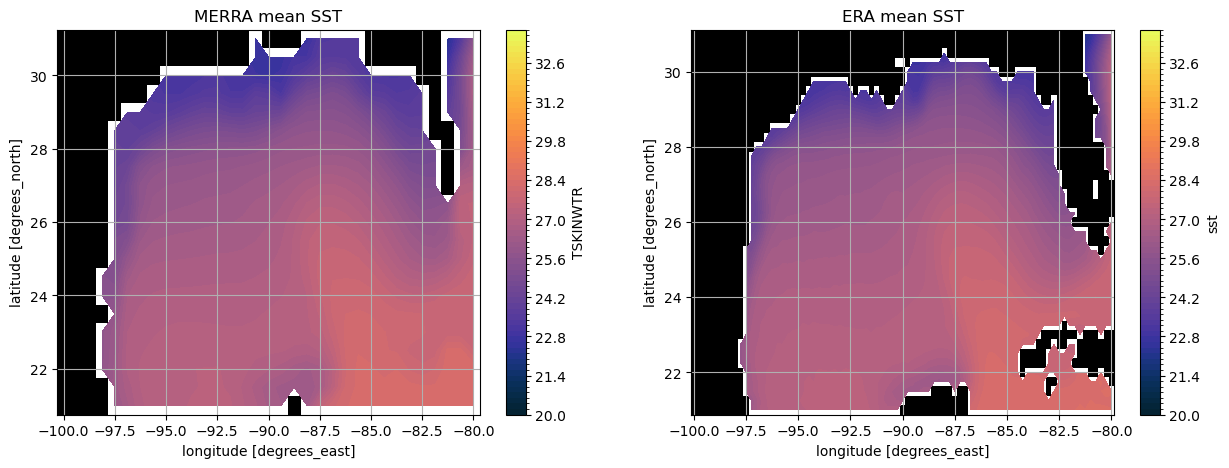

In [24]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
mask_m = merra.TSKINWTR[0].isnull()
cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_m.plot(cmap=cmap, add_colorbar=False, ax=ax0)

merra.TSKINWTR.mean('time').plot.contourf(levels=np.arange(20, 34, 0.2), ax=ax0,
                                          colors=cmocean.cm.thermal, add_colorbar=True)
ax0.clabel(c)
ax0.grid()
ax0.set_title('MERRA mean SST')

mask_e = era.sst[0].isnull()
cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_e.plot(cmap=cmap, add_colorbar=False, ax=ax1)

era.sst.mean('time').plot.contourf(levels=np.arange(20, 34, 0.2), ax=ax1,
                                          colors=cmocean.cm.thermal, add_colorbar=True)
ax1.clabel(c)
ax1.grid()
ax1.set_title('ERA mean SST');

## Plot some things

In [10]:
def plot_timeseries(da_e, da_m, fig_title):
    plt.figure(figsize=(10,4))
    era[f'{da_e}'].mean(['latitude', 'longitude']).plot(label='ERA')
    merra[f'{da_m}'].mean(['lat', 'lon']).plot(label='MERRA')
    plt.grid()
    plt.title(f'{fig_title}')
    plt.ylabel(r'W m$^{-2}$')
    plt.xlabel('Time')
    plt.legend();

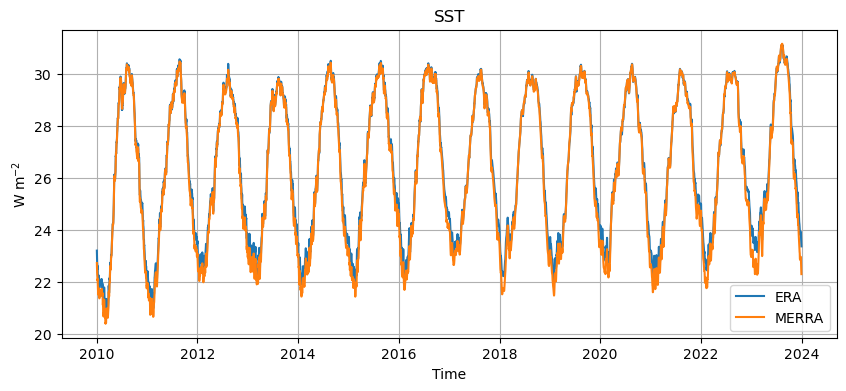

In [11]:
plot_timeseries('sst', 'TSKINWTR', 'SST')

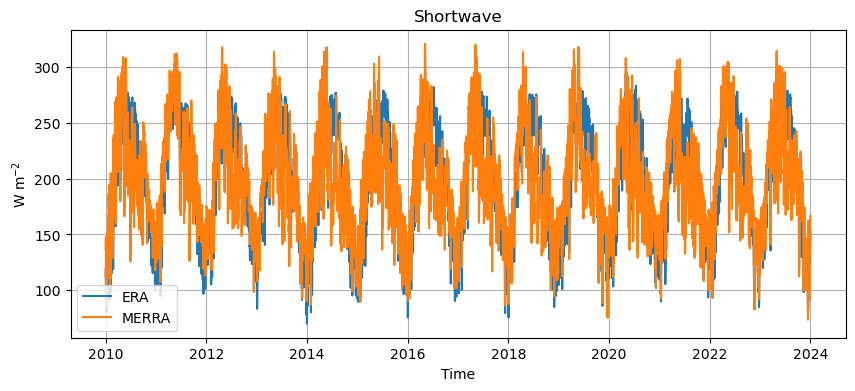

In [18]:
plot_timeseries('ssr', 'SWGNTWTR', 'Shortwave')

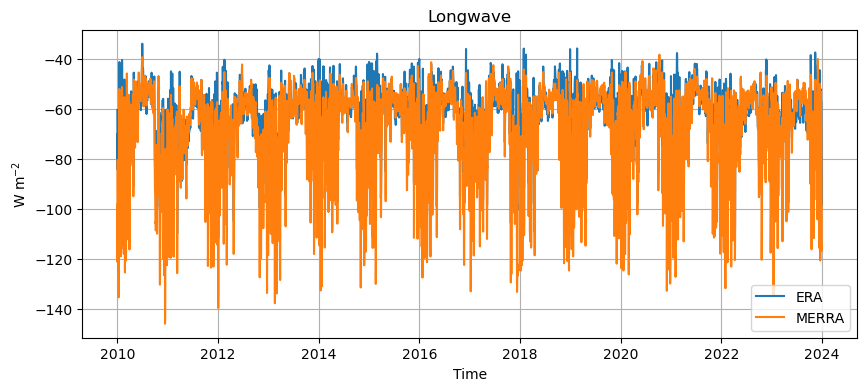

In [19]:
plot_timeseries('str', 'LWGNTWTR', 'Longwave')

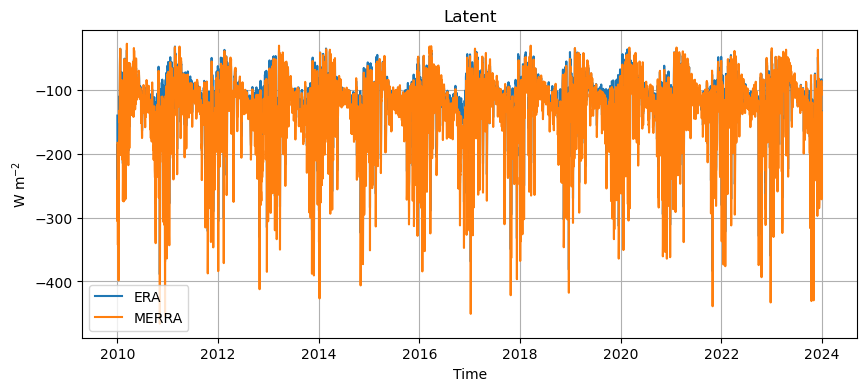

In [20]:
plot_timeseries('slhf', 'EFLUXWTR', 'Latent')

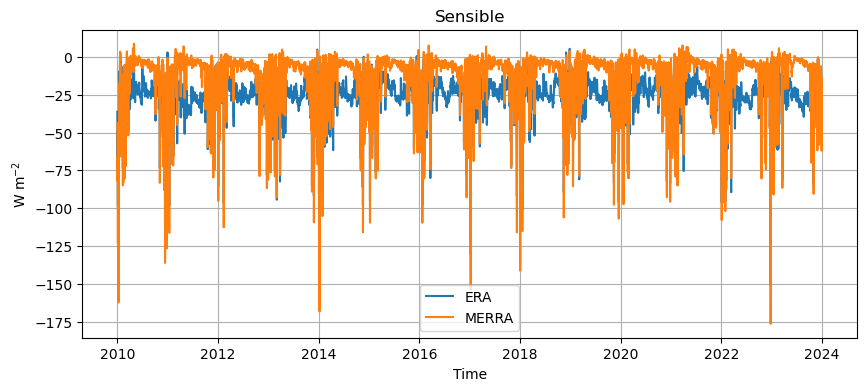

In [21]:
plot_timeseries('sshf', 'HFLUXWTR', 'Sensible')

## Create grid and area objects

In [25]:
ds_full_e = generate_grid_ds(era, {'X':'longitude', 'Y':'latitude'})
ds_full_m = generate_grid_ds(merra, {'X':'lon', 'Y':'lat'})

In [26]:
grid_e = xgcm.Grid(ds_full_e, periodic='X')
grid_m = xgcm.Grid(ds_full_m, periodic='X')

In [27]:
ds_full_e

<xarray.Dataset> Size: 679MB
Dimensions:         (time: 5113, latitude: 41, longitude: 81,
                     longitude_left: 81, latitude_left: 41)
Coordinates:
  * latitude        (latitude) float32 164B 21.0 21.25 21.5 ... 30.5 30.75 31.0
  * longitude       (longitude) float32 324B -100.0 -99.75 ... -80.25 -80.0
  * time            (time) datetime64[ns] 41kB 2010-01-01 ... 2023-12-31
  * longitude_left  (longitude_left) float32 324B -100.1 -99.88 ... -80.12
  * latitude_left   (latitude_left) float32 164B 20.88 21.12 ... 30.62 30.88
Data variables:
    slhf            (time, latitude, longitude) float64 136MB -14.05 ... -380.4
    sshf            (time, latitude, longitude) float64 136MB -41.33 ... -123.3
    ssr             (time, latitude, longitude) float64 136MB 69.84 ... 145.2
    str             (time, latitude, longitude) float64 136MB -40.41 ... -140.9
    sst             (time, latitude, longitude) float64 136MB nan nan ... 23.63
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [28]:
grid_e

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center

In [29]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [30]:
cell_elements_e = deg_2_m(grid_e, ds_full_e, 'latitude', 'longitude')
cell_elements_m = deg_2_m(grid_m, ds_full_m, 'lat', 'lon')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


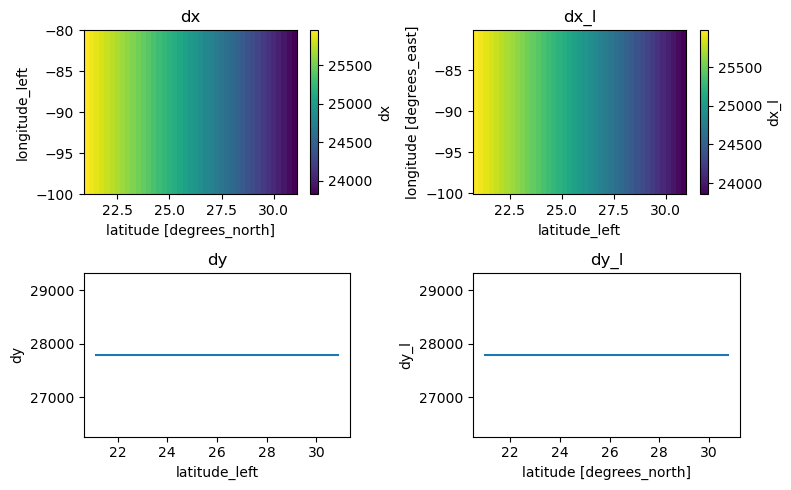

In [31]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_e.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_e.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_e.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_e.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

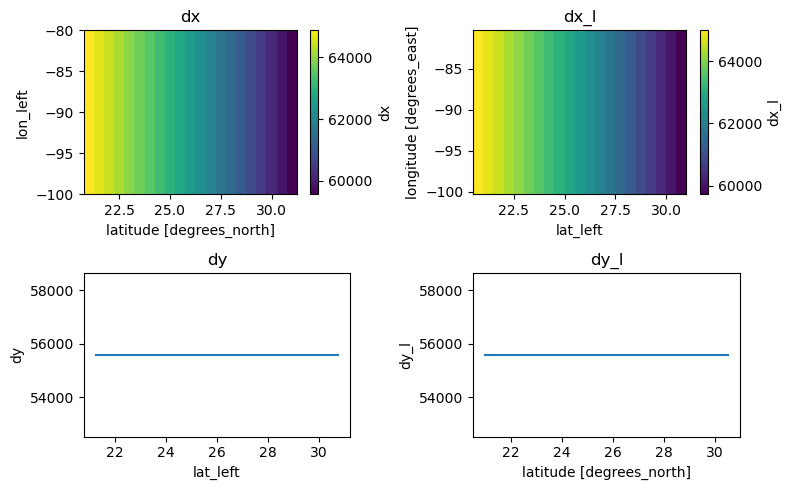

In [32]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_m.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_m.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_m.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_m.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

#### Create mask

In [33]:
mask_e = era.sst[0].isnull()
mask_m = merra.TSKINWTR[0].isnull()

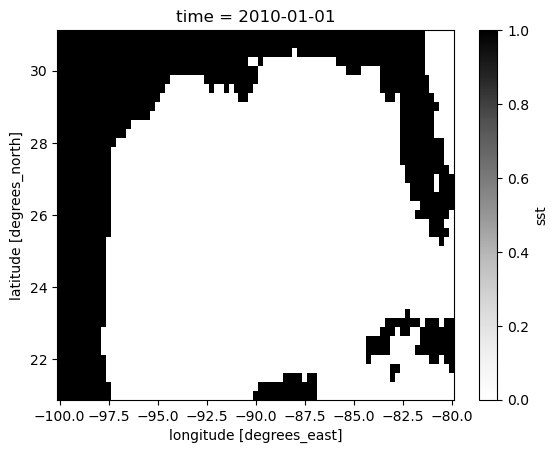

In [34]:
cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_e.plot(cmap=cmap);

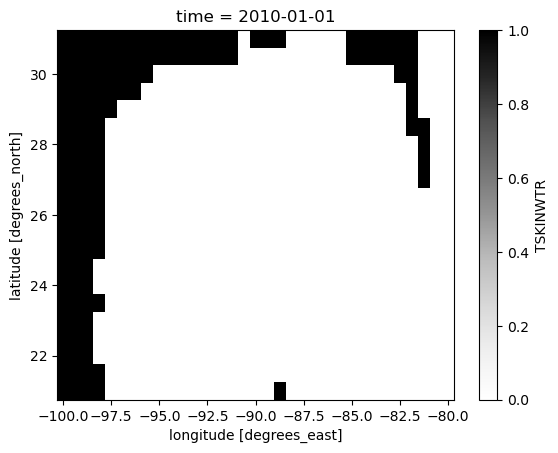

In [35]:
cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_m.plot(cmap=cmap);

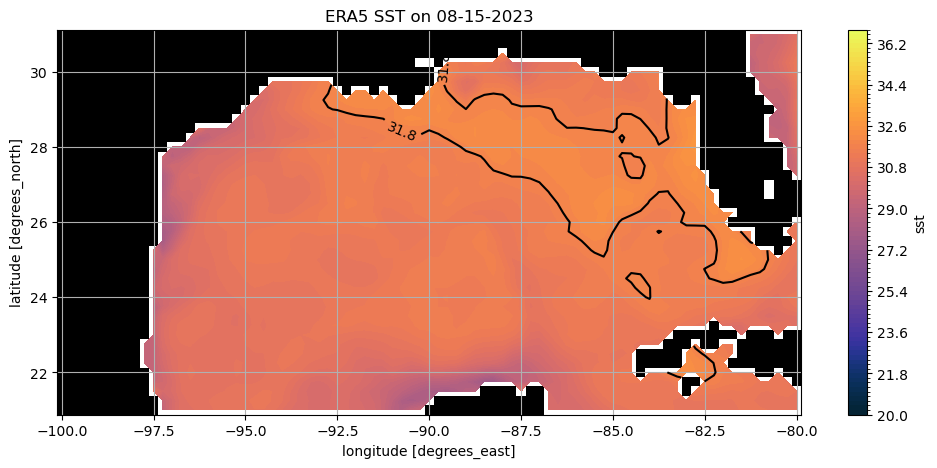

In [60]:
plt.figure(figsize=(12,5))

cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_e.plot(cmap=cmap, add_colorbar=False)

era.sst.sel(time='2023-08-15', method='nearest').plot.contourf(levels=np.arange(20, 37, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = era.sst.sel(time='2023-08-15', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('ERA5 SST on 08-15-2023');

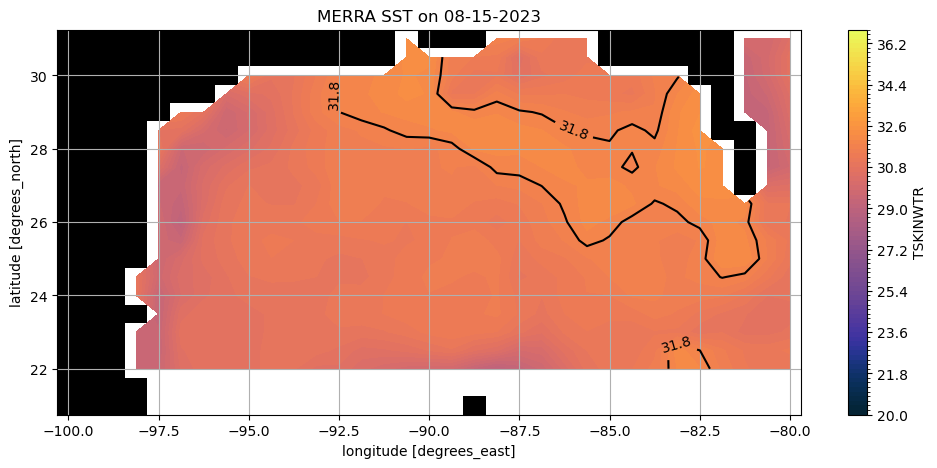

In [61]:
plt.figure(figsize=(12,5))

cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)

mask_m.plot(cmap=cmap, add_colorbar=False)
merra.TSKINWTR.sel(time='2023-08-15', method='nearest').where(~mask_m).plot.contourf(levels=np.arange(20, 37, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = merra.TSKINWTR.sel(time='2023-08-15', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('MERRA SST on 08-15-2023');

### Calculate surface area of 31.8˚C contour

# Budget

In [36]:
dx_interp_e = grid_e.interp(cell_elements_e.dx_l, 'Y')
area_e = dx_interp_e * cell_elements_e.dy_l

dx_interp_m = grid_m.interp(cell_elements_m.dx_l, 'Y')
area_m = dx_interp_m * cell_elements_m.dy_l

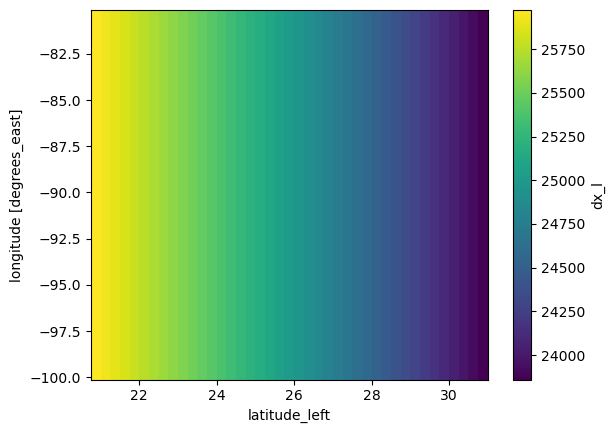

In [37]:
cell_elements_e.dx_l[:-1].plot()

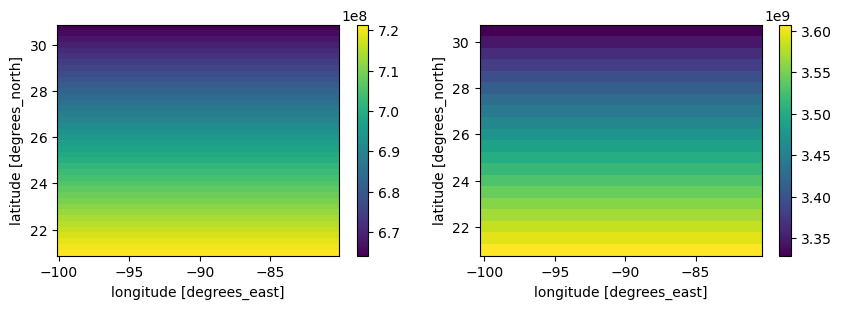

In [38]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
area_e[:-1, :-1].T.plot(ax=ax0)
area_m[:-1, :-1].T.plot(ax=ax1)

In [39]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1027 #kg/m^3 #according to Harte Research Institute(https://www.harteresearch.org/sites/default/files/inline-files/3.pdf)

#(W/m^2) x 1/Cp x 1/rho x area
era_weighted = (era.isel(longitude=slice(None, -1), latitude=slice(None, -1)) * 
                area_e.isel(longitude=slice(None, -1), latitude=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s
merra_weighted = (merra.isel(lon=slice(None, -1), lat=slice(None, -1)) * 
                  area_m.isel(lon=slice(None, -1), lat=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s

In [40]:
delta_theta = 0.1
theta_bins = np.arange(20, 38, delta_theta)

def hist_func(sst, ds, lat, lon, variable):
    hist = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=ds[variable].fillna(0.),
                    dim=[lon, lat]) / delta_theta
    return hist #m^3/s (Sv)

In [55]:
pdf_m = histogram(merra.TSKINWTR, bins=[theta_bins], dim=['lat', 'lon']) / delta_theta
pdf_e = histogram(era.sst, bins=[theta_bins], dim=['latitude', 'longitude']) / delta_theta

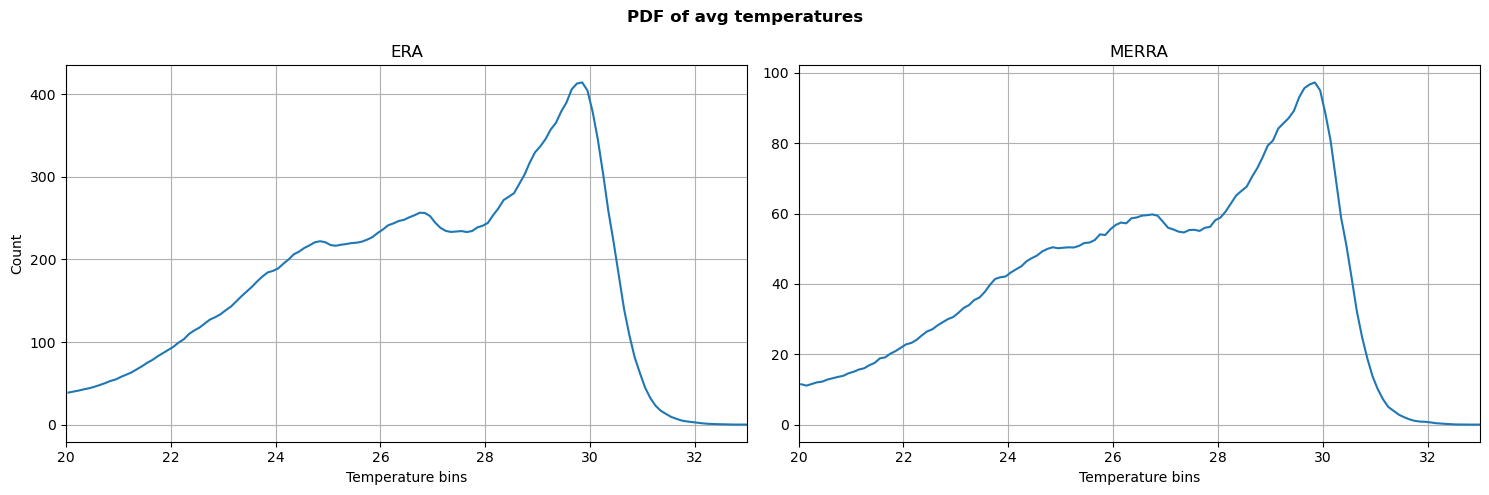

In [66]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5), sharex=True)
pdf_e.mean('time').plot(ax=ax0)
ax0.grid()
ax0.set_xlim(20,33)
ax0.set_title('ERA')
ax0.set_xlabel('Temperature bins')
ax0.set_ylabel('Count')

pdf_m.mean('time').plot(ax=ax1)
ax1.grid()
ax1.set_title('MERRA')
ax1.set_xlabel('Temperature bins')
ax1.set_ylabel('')

plt.suptitle('PDF of avg temperatures', fontweight='bold')
plt.tight_layout();

In [41]:
era_weighted.coords

Coordinates:
  * latitude   (latitude) float32 160B 21.0 21.25 21.5 ... 30.25 30.5 30.75
  * longitude  (longitude) float32 320B -100.0 -99.75 -99.5 ... -80.5 -80.25
  * time       (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31

In [42]:
era.sst.isel(longitude=slice(None, -1), latitude=slice(None, -1)).coords

Coordinates:
  * latitude   (latitude) float32 160B 21.0 21.25 21.5 ... 30.25 30.5 30.75
  * longitude  (longitude) float32 320B -100.0 -99.75 -99.5 ... -80.5 -80.25
  * time       (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31

In [43]:
merra_weighted.coords

Coordinates:
  * lat      (lat) float64 160B 21.0 21.5 22.0 22.5 23.0 ... 29.0 29.5 30.0 30.5
  * lon      (lon) float64 256B -100.0 -99.38 -98.75 ... -81.88 -81.25 -80.62
  * time     (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31

In [44]:
merra.TSKINWTR.isel(lon=slice(None, -1), lat=slice(None, -1)).coords

Coordinates:
  * lat      (lat) float64 160B 21.0 21.5 22.0 22.5 23.0 ... 29.0 29.5 30.0 30.5
  * lon      (lon) float64 256B -100.0 -99.38 -98.75 ... -81.88 -81.25 -80.62
  * time     (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31

In [45]:
sst_e = era.sst.isel(longitude=slice(None, -1), latitude=slice(None, -1)).where(~mask_e)
era_hist = xr.merge([hist_func(sst_e, 
                               era_weighted.where(~mask_e),
                               'latitude', 'longitude', var).rename('omega_'+var) 
                     for var in list(era_weighted)[:-1]])
sst_m = merra.TSKINWTR.isel(lon=slice(None, -1), lat=slice(None, -1)).where(~mask_m)
merra_hist = xr.merge([hist_func(sst_m, 
                                 merra_weighted.where(~mask_m),
                                 'lat', 'lon', var).rename('omega_'+var)
                      for var in list(merra_weighted)[:-1]])

In [46]:
era_hist

<xarray.Dataset> Size: 29MB
Dimensions:     (time: 5113, theta_bin: 179)
Coordinates:
  * time        (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31
  * theta_bin   (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.65 37.75 37.85
Data variables:
    omega_slhf  (time, theta_bin) float64 7MB -3.057e+06 -4.519e+06 ... 0.0 0.0
    omega_sshf  (time, theta_bin) float64 7MB -1.146e+06 -1.727e+06 ... 0.0 0.0
    omega_ssr   (time, theta_bin) float64 7MB 1.404e+06 1.855e+06 ... 0.0 0.0
    omega_str   (time, theta_bin) float64 7MB -1.073e+06 -1.398e+06 ... 0.0 0.0

In [47]:
merra_hist#.load()

<xarray.Dataset> Size: 29MB
Dimensions:         (time: 5113, theta_bin: 179)
Coordinates:
  * time            (time) datetime64[ns] 41kB 2010-01-01 ... 2023-12-31
  * theta_bin       (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.75 37.85
Data variables:
    omega_EFLUXWTR  (time, theta_bin) float64 7MB -4.748e+06 -4.167e+06 ... 0.0
    omega_HFLUXWTR  (time, theta_bin) float64 7MB -1.653e+06 -1.41e+06 ... 0.0
    omega_LWGNTWTR  (time, theta_bin) float64 7MB -2.539e+06 -2.29e+06 ... 0.0
    omega_SWGNTWTR  (time, theta_bin) float64 7MB 3.672e+06 3.217e+06 ... 0.0

In [38]:
mo_sst_e = sst_e.groupby('time.month').mean('time')
mo_sst_m = sst_m.groupby('time.month').mean('time')

In [139]:
sst_e = era.sst.isel(longitude=slice(None, -1), latitude=slice(None, -1)).where(~mask_e)
era_hist_sst_clim = xr.merge([hist_func(mo_sst_e, 
                               era_weighted.where(~mask_e),
                               'latitude', 'longitude', var).rename('omega_'+var) 
                     for var in list(era_weighted)[:-1]])
#sst_m = merra.TSKINWTR.isel(lon=slice(None, -1), lat=slice(None, -1)).where(~mask_m)
#merra_hist_sst_clim = xr.merge([hist_func(mo_sst_m, 
#                                 merra_weighted.where(~mask_m),
#                                 'lat', 'lon', var).rename('omega_'+var)
#                      for var in list(merra_weighted)[:-1]])

In [142]:
a

<xarray.DataArray (x: 3)> Size: 24B
array([1, 2, 3])
Dimensions without coordinates: x

In [144]:
a2

<xarray.DataArray (x: 3, y: 2)> Size: 48B
array([[1, 1],
       [2, 2],
       [3, 3]])
Dimensions without coordinates: x, y

In [151]:
(sst_br, era_br) = xr.broadcast(mo_sst_e.month, era_weighted.time)

In [155]:
sst_br

<xarray.DataArray 'month' (month: 12, time: 5113)> Size: 491kB
array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  3,  3,  3],
       ...,
       [10, 10, 10, ..., 10, 10, 10],
       [11, 11, 11, ..., 11, 11, 11],
       [12, 12, 12, ..., 12, 12, 12]])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 41kB 2010-01-01 2010-01-02 ... 2023-12-31

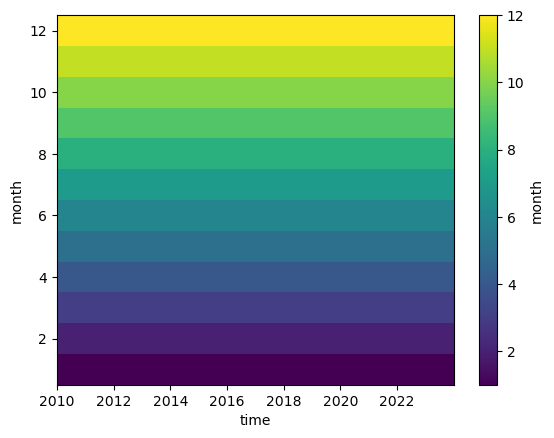

In [154]:
sst_br.plot()

In [143]:
b

<xarray.DataArray (y: 2)> Size: 16B
array([5, 6])
Dimensions without coordinates: y

In [141]:
xr.broadcast()
a = xr.DataArray([1, 2, 3], dims="x")
b = xr.DataArray([5, 6], dims="y")
a2, b2 = xr.broadcast(a, b)

ds = xr.Dataset({"a": a, "b": b})
(ds2,) = xr.broadcast(ds)  # use tuple unpacking to extract one dataset
ds2

<xarray.Dataset> Size: 96B
Dimensions:  (x: 3, y: 2)
Dimensions without coordinates: x, y
Data variables:
    a        (x, y) int64 48B 1 1 2 2 3 3
    b        (x, y) int64 48B 5 6 5 6 5 6

In [114]:
months = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
month_length = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
daily_mo = []

for (i,j) in zip(months, month_length):
    daily_mo.append([i]*j)

In [129]:
daily_year = daily_mo*14

In [93]:
59+31

90

In [96]:
era_weighted.time.dt.month[59:90]

<xarray.DataArray 'month' (time: 31)> Size: 248B
array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3])
Coordinates:
  * time     (time) datetime64[ns] 248B 2010-03-01 2010-03-02 ... 2010-03-31

In [47]:
5113/365

14.008219178082191

In [54]:
era_weighted.time.sel(time=slice('2010-01-01', '2010-01-31'))

<xarray.DataArray 'time' (time: 31)> Size: 248B
array(['2010-01-01T00:00:00.000000000', '2010-01-02T00:00:00.000000000',
       '2010-01-03T00:00:00.000000000', '2010-01-04T00:00:00.000000000',
       '2010-01-05T00:00:00.000000000', '2010-01-06T00:00:00.000000000',
       '2010-01-07T00:00:00.000000000', '2010-01-08T00:00:00.000000000',
       '2010-01-09T00:00:00.000000000', '2010-01-10T00:00:00.000000000',
       '2010-01-11T00:00:00.000000000', '2010-01-12T00:00:00.000000000',
       '2010-01-13T00:00:00.000000000', '2010-01-14T00:00:00.000000000',
       '2010-01-15T00:00:00.000000000', '2010-01-16T00:00:00.000000000',
       '2010-01-17T00:00:00.000000000', '2010-01-18T00:00:00.000000000',
       '2010-01-19T00:00:00.000000000', '2010-01-20T00:00:00.000000000',
       '2010-01-21T00:00:00.000000000', '2010-01-22T00:00:00.000000000',
       '2010-01-23T00:00:00.000000000', '2010-01-24T00:00:00.000000000',
       '2010-01-25T00:00:00.000000000', '2010-01-26T00:00:00.000000000',
       '2010-01-27T00:00:00.000000000', '2010-01-28T00:00:00.000000000',
       '2010-01-29T00:00:00.000000000', '2010-01-30T00:00:00.000000000',
       '2010-01-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 248B 2010-01-01 2010-01-02 ... 2010-01-31

<Figure size 2500x500 with 0 Axes>

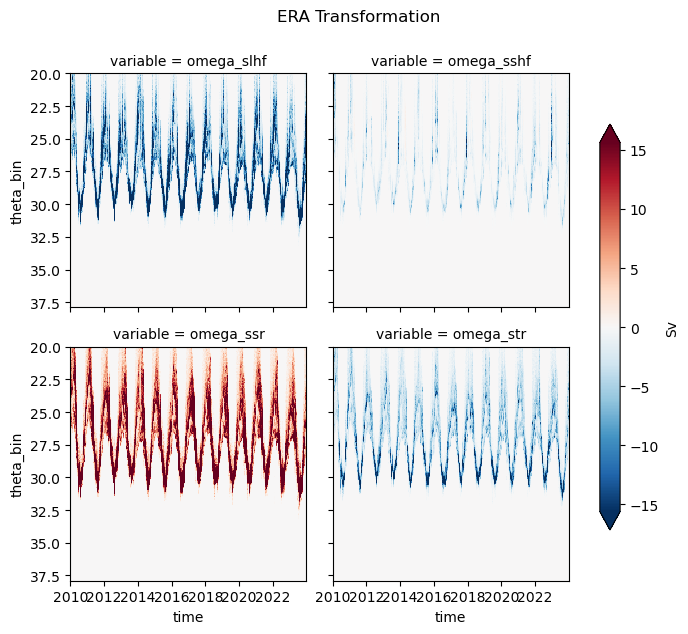

In [34]:
plt.figure(figsize=(25,5))
(era_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True, 
                               cbar_kwargs={'shrink': 0.8, 'label':'Sv'})
plt.suptitle('ERA Transformation', y=1.05);

<Figure size 2500x500 with 0 Axes>

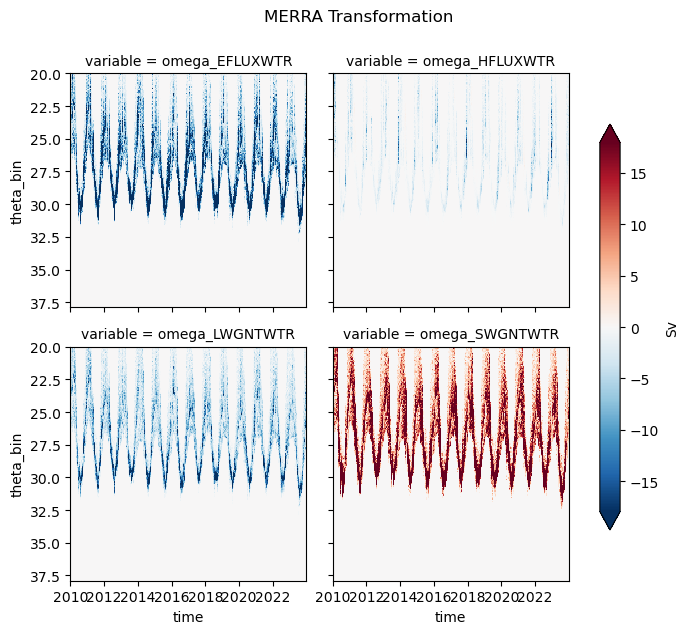

In [35]:
plt.figure(figsize=(25,5))
(merra_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True, 
                               cbar_kwargs={'shrink': 0.8, 'label':'Sv'})
plt.suptitle('MERRA Transformation', y=1.05);

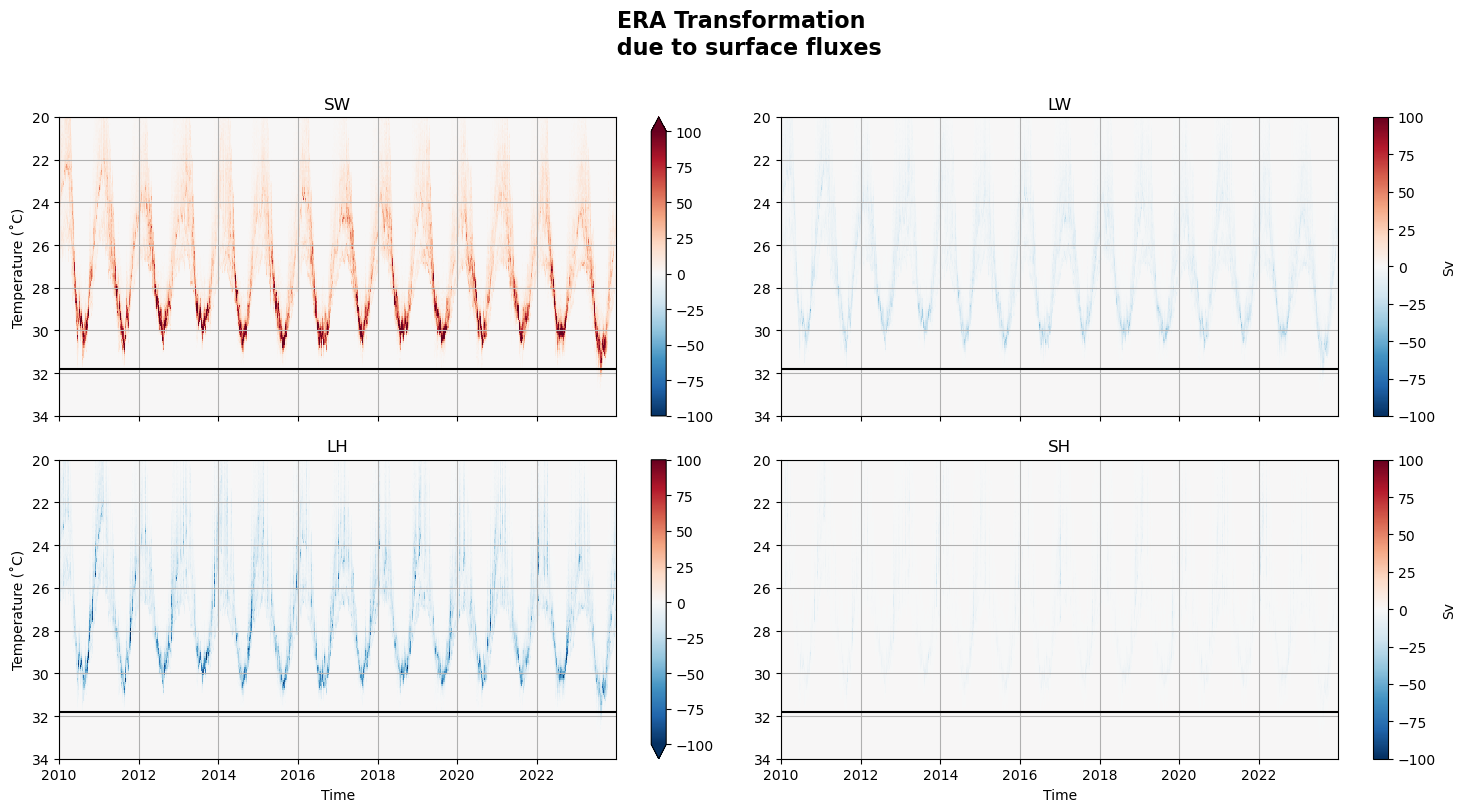

In [96]:
fig, ax = plt.subplots(2,2, figsize=(15,8), sharex=True)
(era_hist.omega_ssr/1e6).T.plot(label='SW', ax=ax[0,0], vmax=100, vmin=-100, 
                                       cmap='RdBu_r',cbar_kwargs={'label':''})
ax[0,0].set_ylim(34,20)
ax[0,0].grid()
ax[0,0].set_title('SW')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Temperature (˚C)')
ax[0,0].axhline(31.8, color='k')
(era_hist.omega_str/1e6).T.plot(label='LW', ax=ax[0,1], vmax=100, vmin=-100, 
                                       cmap='RdBu_r',cbar_kwargs={'label':'Sv'})
ax[0,1].set_ylim(34,20)
ax[0,1].grid()
ax[0,1].set_title('LW')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].axhline(31.8, color='k')
(era_hist.omega_slhf/1e6).T.plot(label='LH', ax=ax[1,0], vmax=100, vmin=-100, 
                                       cmap='RdBu_r', cbar_kwargs={'label':''})
ax[1,0].set_ylim(34,20)
ax[1,0].grid()
ax[1,0].set_title('LH')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Temperature (˚C)')
ax[1,0].axhline(31.8, color='k')
(era_hist.omega_sshf/1e6).T.plot(label='SH', ax=ax[1,1], vmax=100, vmin=-100, 
                                       cmap='RdBu_r', cbar_kwargs={'label':'Sv'})
ax[1,1].set_ylim(34,20)
ax[1,1].grid()
ax[1,1].set_title('SH')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('')
ax[1,1].axhline(31.8, color='k')

plt.suptitle('ERA Transformation \n due to surface fluxes', y=1.01, fontsize=16, weight='bold')
plt.tight_layout();

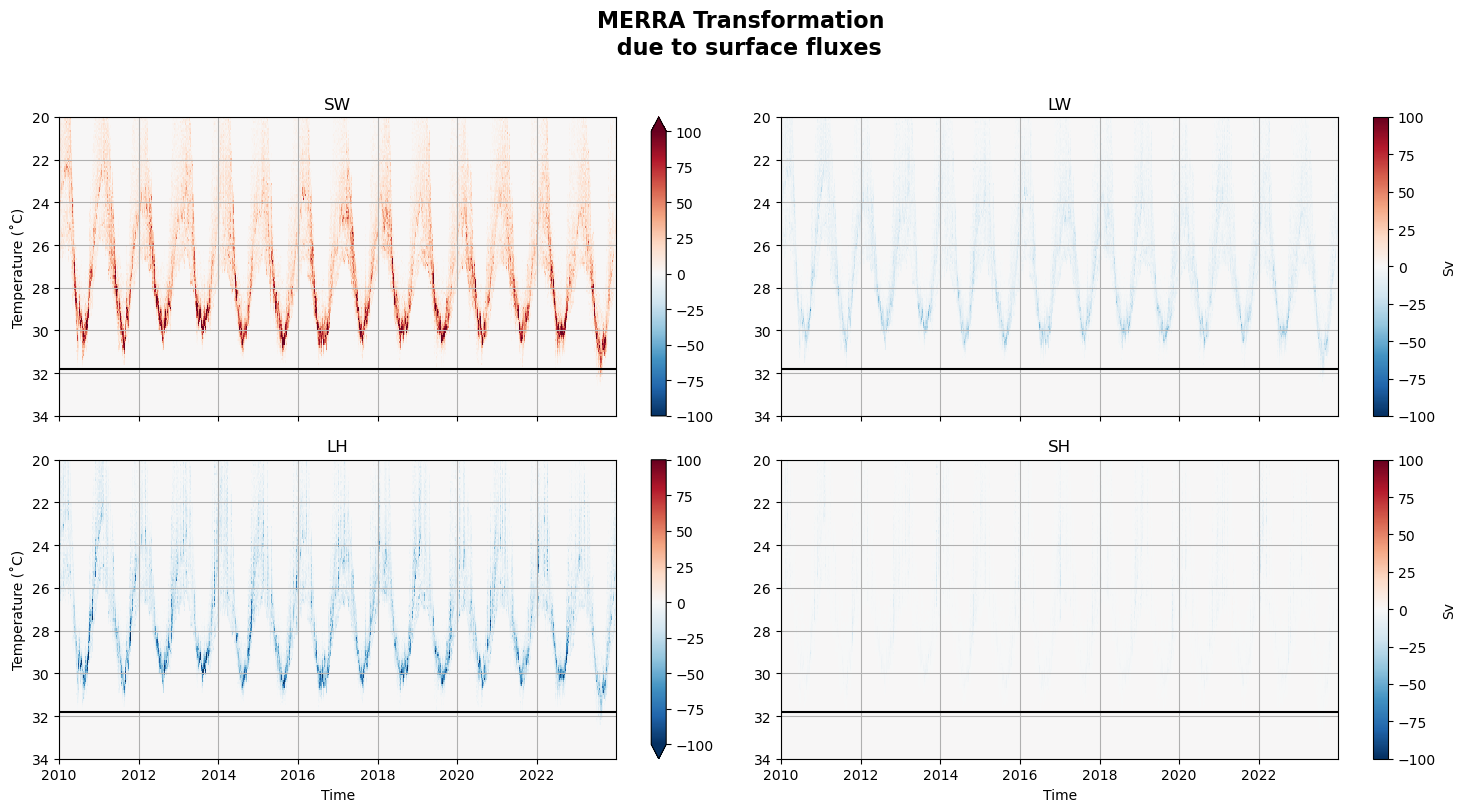

In [97]:
fig, ax = plt.subplots(2,2, figsize=(15,8), sharex=True)
(merra_hist.omega_SWGNTWTR/1e6).T.plot(ax=ax[0,0], vmax=100, vmin=-100, 
                                       cmap='RdBu_r', cbar_kwargs={'label':''})
ax[0,0].set_ylim(34,20)
ax[0,0].grid()
ax[0,0].set_title('SW')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Temperature (˚C)')
ax[0,0].axhline(31.8, color='k')
(merra_hist.omega_LWGNTWTR/1e6).T.plot(ax=ax[0,1], vmax=100, vmin=-100,
                                       cmap='RdBu_r', cbar_kwargs={'label':'Sv'})
ax[0,1].set_ylim(34,20)
ax[0,1].grid()
ax[0,1].set_title('LW')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].axhline(31.8, color='k')
(merra_hist.omega_EFLUXWTR/1e6).T.plot(ax=ax[1,0], vmax=100, vmin=-100,  
                                       cmap='RdBu_r', cbar_kwargs={'label':''})
ax[1,0].set_ylim(34,20)
ax[1,0].grid()
ax[1,0].set_title('LH')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Temperature (˚C)')
ax[1,0].axhline(31.8, color='k')
(merra_hist.omega_HFLUXWTR/1e6).T.plot(ax=ax[1,1], vmax=100, vmin=-100,
                                       cmap='RdBu_r', cbar_kwargs={'label':'Sv'})
ax[1,1].set_ylim(34,20)
ax[1,1].grid()
ax[1,1].set_title('SH')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('')
ax[1,1].axhline(31.8, color='k')

plt.suptitle('MERRA Transformation \n due to surface fluxes', y=1.01, fontsize=16, weight='bold')
plt.tight_layout();

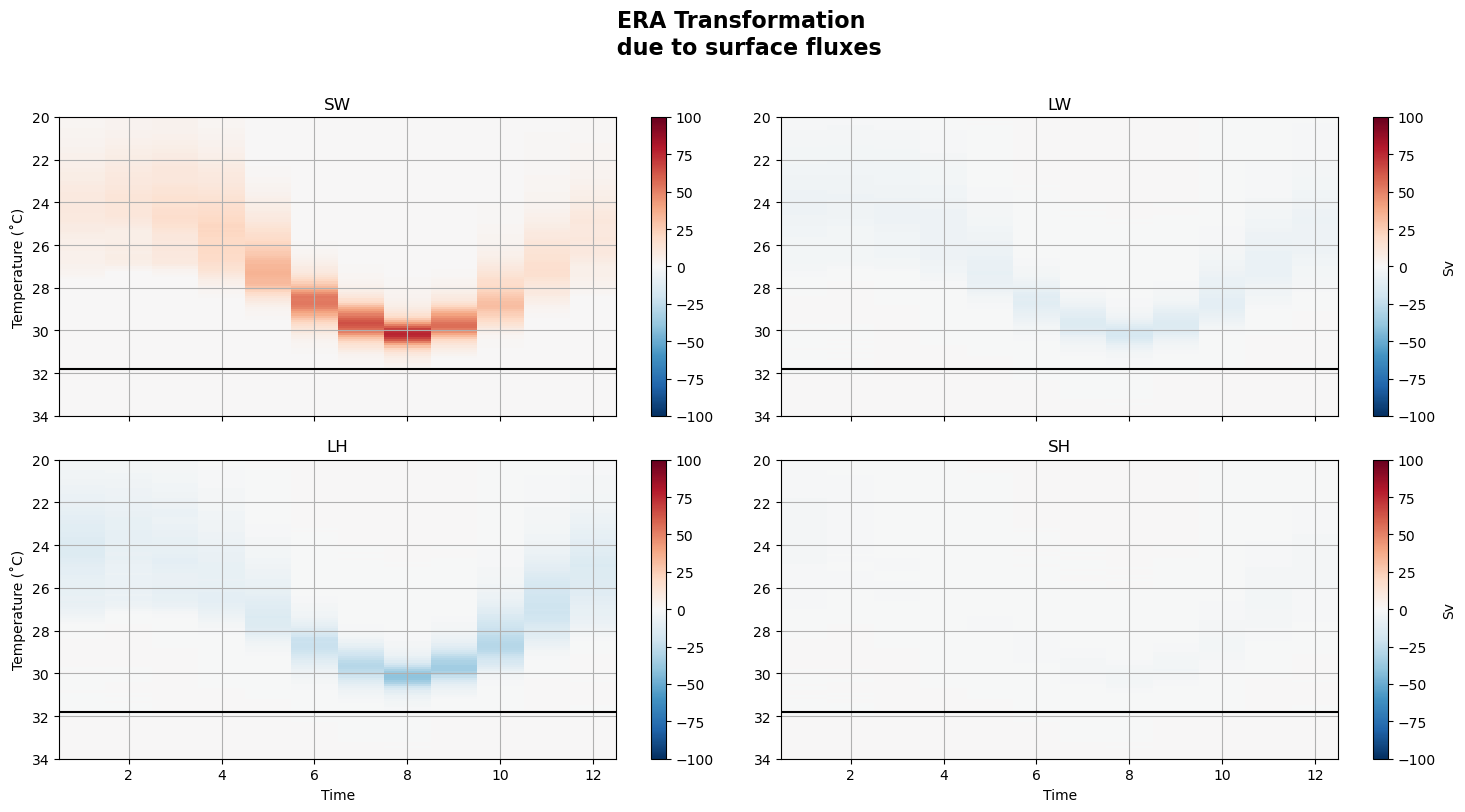

In [51]:
fig, ax = plt.subplots(2,2, figsize=(15,8), sharex=True)
(era_hist.omega_ssr.groupby('time.month').mean('time')/1e6).T.plot(label='SW', ax=ax[0,0], vmax=100, vmin=-100, 
                                       cmap='RdBu_r',cbar_kwargs={'label':''})
ax[0,0].set_ylim(34,20)
ax[0,0].grid()
ax[0,0].set_title('SW')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Temperature (˚C)')
ax[0,0].axhline(31.8, color='k')
(era_hist.omega_str.groupby('time.month').mean('time')/1e6).T.plot(label='LW', ax=ax[0,1], vmax=100, vmin=-100, 
                                       cmap='RdBu_r',cbar_kwargs={'label':'Sv'})
ax[0,1].set_ylim(34,20)
ax[0,1].grid()
ax[0,1].set_title('LW')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].axhline(31.8, color='k')
(era_hist.omega_slhf.groupby('time.month').mean('time')/1e6).T.plot(label='LH', ax=ax[1,0], vmax=100, vmin=-100, 
                                       cmap='RdBu_r', cbar_kwargs={'label':''})
ax[1,0].set_ylim(34,20)
ax[1,0].grid()
ax[1,0].set_title('LH')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Temperature (˚C)')
ax[1,0].axhline(31.8, color='k')
(era_hist.omega_sshf.groupby('time.month').mean('time')/1e6).T.plot(label='SH', ax=ax[1,1], vmax=100, vmin=-100, 
                                       cmap='RdBu_r', cbar_kwargs={'label':'Sv'})
ax[1,1].set_ylim(34,20)
ax[1,1].grid()
ax[1,1].set_title('SH')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('')
ax[1,1].axhline(31.8, color='k')

plt.suptitle('ERA Transformation \n due to surface fluxes', y=1.01, fontsize=16, weight='bold')
plt.tight_layout();

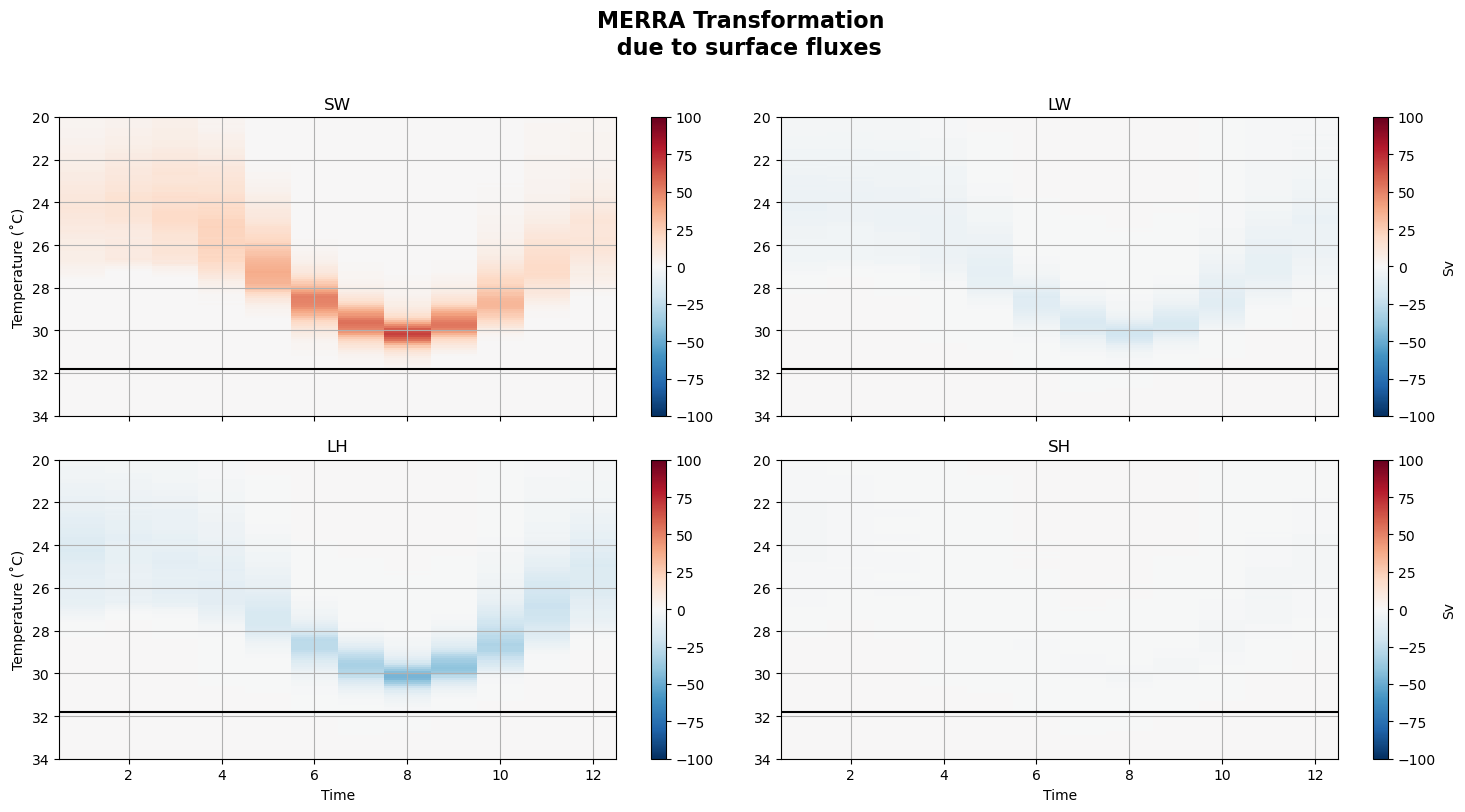

In [52]:
fig, ax = plt.subplots(2,2, figsize=(15,8), sharex=True)
(merra_hist.omega_SWGNTWTR.groupby('time.month').mean('time')/1e6).T.plot(ax=ax[0,0], vmax=100, vmin=-100, 
                                       cmap='RdBu_r', cbar_kwargs={'label':''})
ax[0,0].set_ylim(34,20)
ax[0,0].grid()
ax[0,0].set_title('SW')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Temperature (˚C)')
ax[0,0].axhline(31.8, color='k')
(merra_hist.omega_LWGNTWTR.groupby('time.month').mean('time')/1e6).T.plot(ax=ax[0,1], vmax=100, vmin=-100,
                                       cmap='RdBu_r', cbar_kwargs={'label':'Sv'})
ax[0,1].set_ylim(34,20)
ax[0,1].grid()
ax[0,1].set_title('LW')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].axhline(31.8, color='k')
(merra_hist.omega_EFLUXWTR.groupby('time.month').mean('time')/1e6).T.plot(ax=ax[1,0], vmax=100, vmin=-100,  
                                       cmap='RdBu_r', cbar_kwargs={'label':''})
ax[1,0].set_ylim(34,20)
ax[1,0].grid()
ax[1,0].set_title('LH')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Temperature (˚C)')
ax[1,0].axhline(31.8, color='k')
(merra_hist.omega_HFLUXWTR.groupby('time.month').mean('time')/1e6).T.plot(ax=ax[1,1], vmax=100, vmin=-100,
                                       cmap='RdBu_r', cbar_kwargs={'label':'Sv'})
ax[1,1].set_ylim(34,20)
ax[1,1].grid()
ax[1,1].set_title('SH')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('')
ax[1,1].axhline(31.8, color='k')

plt.suptitle('MERRA Transformation \n due to surface fluxes', y=1.01, fontsize=16, weight='bold')
plt.tight_layout();

### Temp at which max transformation occurs

In [26]:
max_trans_era = era_hist.idxmax(dim='theta_bin')
max_trans_merra = merra_hist.idxmax(dim='theta_bin')

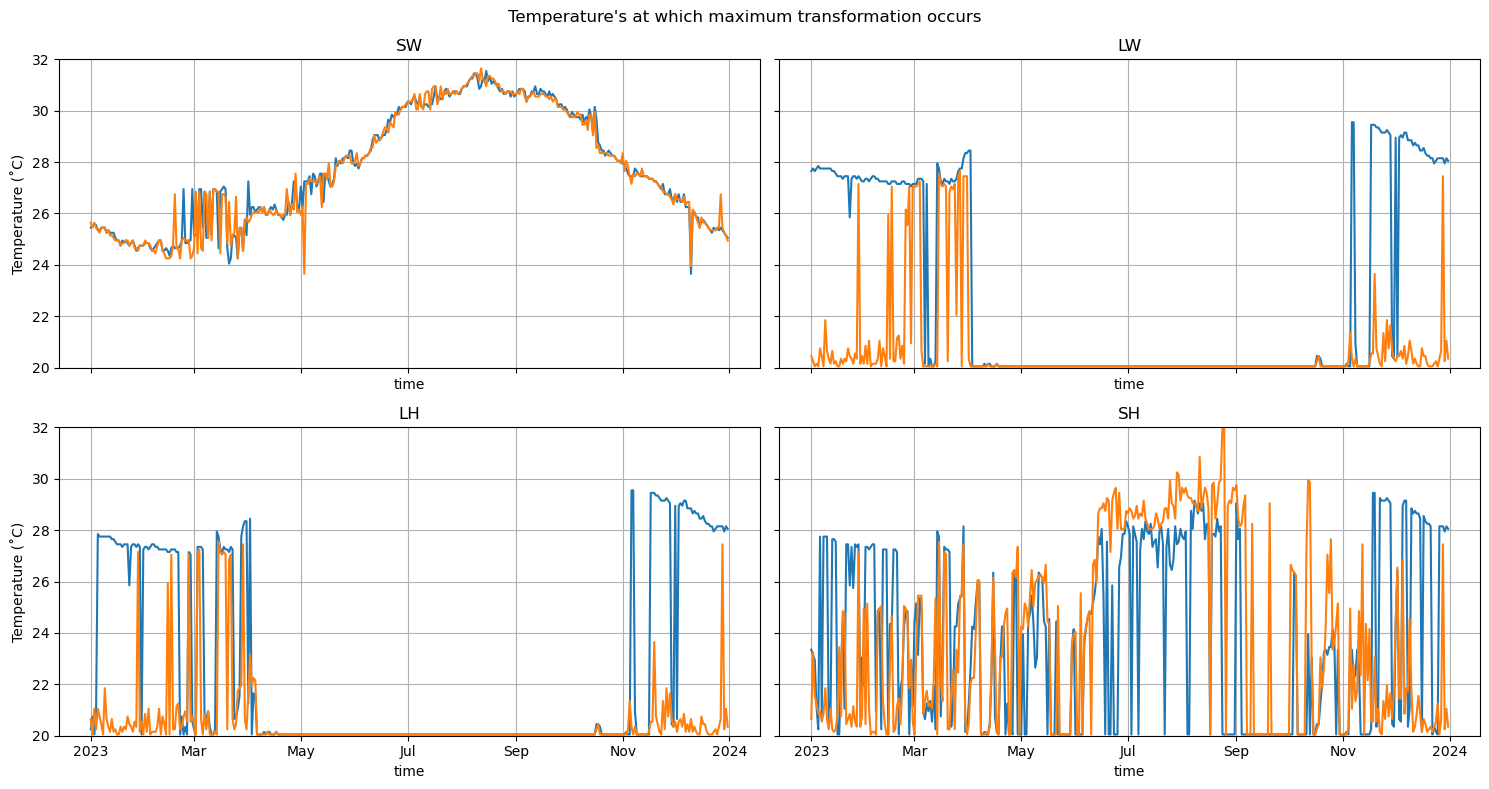

In [46]:
fig, ax = plt.subplots(2,2, figsize=(15,8), sharey=True, sharex=True)
year = dict(time=slice('2023', '2023'))

max_trans_era.omega_ssr.sel(**year).plot(ax=ax[0,0], label='ERA')
max_trans_merra.omega_SWGNTWTR.sel(**year).plot(ax=ax[0,0], label='MERRA')
ax[0,0].set_title('SW')
ax[0,0].grid()
ax[0,0].set_ylabel('Temperature (˚C)')
ax[0,0].set_ylim(20, 32)

max_trans_era.omega_str.sel(**year).plot(ax=ax[0,1], label='ERA')
max_trans_merra.omega_LWGNTWTR.sel(**year).plot(ax=ax[0,1], label='MERRA')
ax[0,1].set_title('LW')
ax[0,1].grid()
ax[0,1].set_ylabel('')

max_trans_era.omega_slhf.sel(**year).plot(ax=ax[1,0], label='ERA')
max_trans_merra.omega_EFLUXWTR.sel(**year).plot(ax=ax[1,0], label='MERRA')
ax[1,0].set_title('LH')
ax[1,0].grid()
ax[1,0].set_ylabel('Temperature (˚C)')

max_trans_era.omega_sshf.sel(**year).plot(ax=ax[1,1], label='ERA')
max_trans_merra.omega_HFLUXWTR.sel(**year).plot(ax=ax[1,1], label='MERRA')
ax[1,1].set_title('SH')
ax[1,1].grid()
ax[1,1].set_ylabel('')

plt.suptitle("Temperature's at which maximum transformation occurs")
plt.tight_layout();

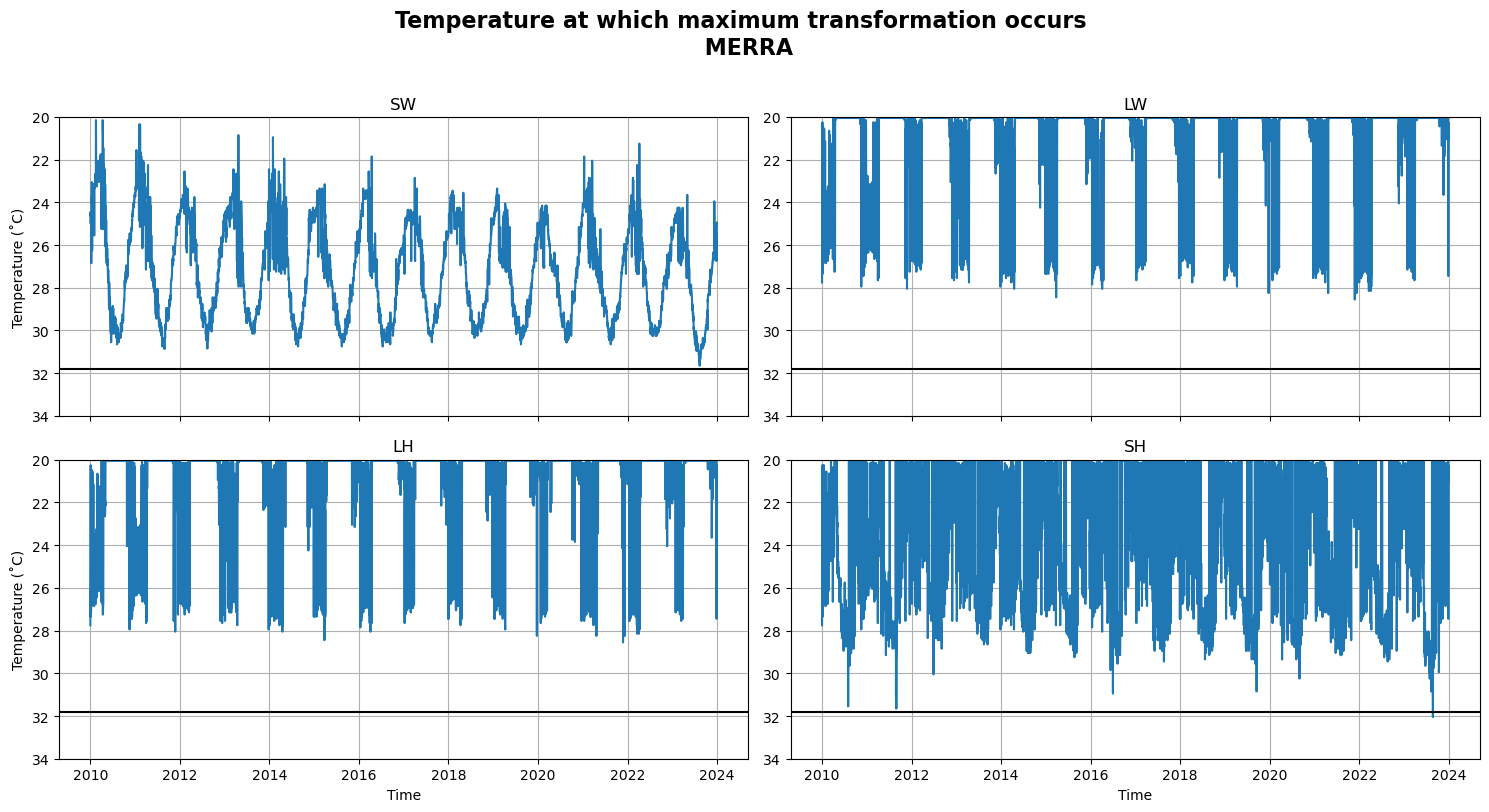

In [126]:
fig, ax = plt.subplots(2,2, figsize=(15,8), sharex=True)
max_trans_merra.omega_SWGNTWTR.plot(ax=ax[0,0])
ax[0,0].set_ylim(34,20)
ax[0,0].grid()
ax[0,0].set_title('SW')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Temperature (˚C)')
ax[0,0].axhline(31.8, color='k')
max_trans_merra.omega_LWGNTWTR.plot(ax=ax[0,1])
ax[0,1].set_ylim(34,20)
ax[0,1].grid()
ax[0,1].set_title('LW')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].axhline(31.8, color='k')
max_trans_merra.omega_EFLUXWTR.plot(ax=ax[1,0])
ax[1,0].set_ylim(34,20)
ax[1,0].grid()
ax[1,0].set_title('LH')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Temperature (˚C)')
ax[1,0].axhline(31.8, color='k')
max_trans_merra.omega_HFLUXWTR.plot(ax=ax[1,1])
ax[1,1].set_ylim(34,20)
ax[1,1].grid()
ax[1,1].set_title('SH')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('')
ax[1,1].axhline(31.8, color='k')

plt.suptitle('Temperature at which maximum transformation occurs \n MERRA', y=1.01, fontsize=16, weight='bold')
plt.tight_layout();

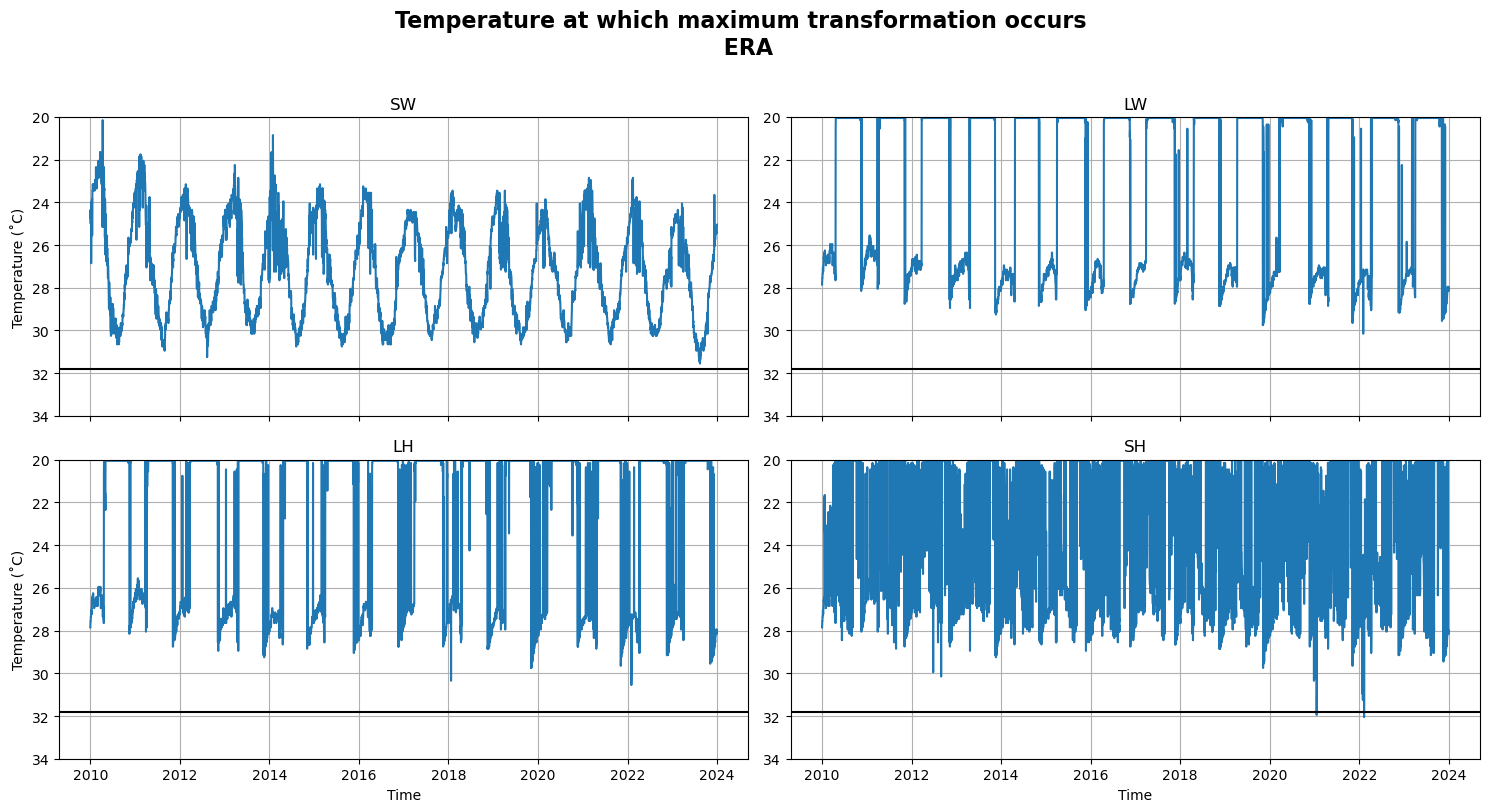

In [128]:
fig, ax = plt.subplots(2,2, figsize=(15,8), sharex=True)
max_trans_era.omega_ssr.plot(ax=ax[0,0])
ax[0,0].set_ylim(34,20)
ax[0,0].grid()
ax[0,0].set_title('SW')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Temperature (˚C)')
ax[0,0].axhline(31.8, color='k')
max_trans_era.omega_str.plot(ax=ax[0,1])
ax[0,1].set_ylim(34,20)
ax[0,1].grid()
ax[0,1].set_title('LW')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].axhline(31.8, color='k')
max_trans_era.omega_slhf.plot(ax=ax[1,0])
ax[1,0].set_ylim(34,20)
ax[1,0].grid()
ax[1,0].set_title('LH')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Temperature (˚C)')
ax[1,0].axhline(31.8, color='k')
max_trans_era.omega_sshf.plot(ax=ax[1,1])
ax[1,1].set_ylim(34,20)
ax[1,1].grid()
ax[1,1].set_title('SH')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('')
ax[1,1].axhline(31.8, color='k')

plt.suptitle('Temperature at which maximum transformation occurs \n ERA', y=1.01, fontsize=16, weight='bold')
plt.tight_layout();

### Select 31.8˚ isotherm

In [36]:
#check to see how many times wwm==31.8˚C occured 
one_plt_era = era_hist.sel(theta_bin=31.8, method='nearest')
one_plt_merra = merra_hist.sel(theta_bin=31.8, method='nearest')

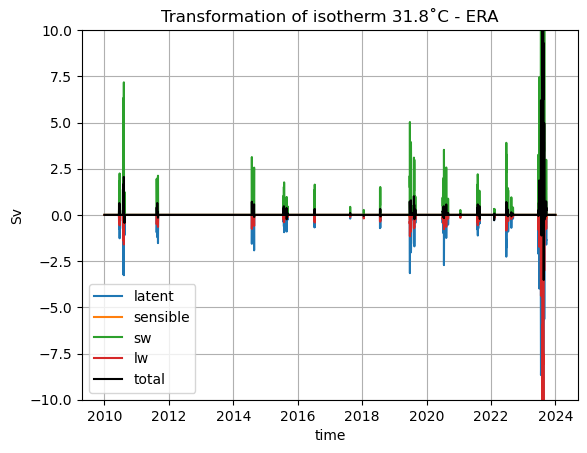

In [37]:
(one_plt_era.omega_slhf/1e6).plot(label='latent')
(one_plt_era.omega_sshf/1e6).plot(label='sensible')
(one_plt_era.omega_ssr/1e6).plot(label='sw')
(one_plt_era.omega_str/1e6).plot(label='lw')
(one_plt_era/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.ylabel('Sv')
plt.ylim(-10,10)
plt.grid()
plt.title('Transformation of isotherm 31.8˚C - ERA');

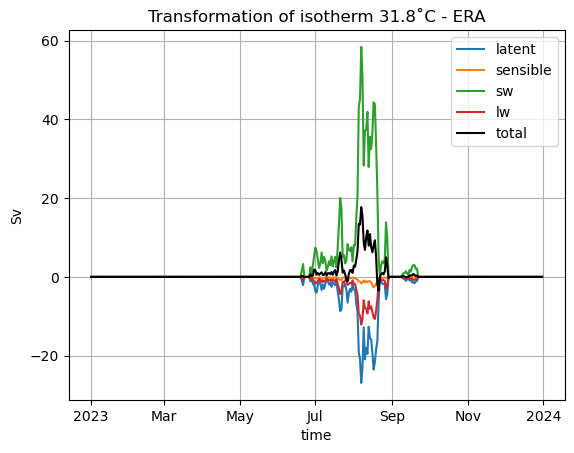

In [49]:
years = dict(time=slice('2023', '2023'))
(one_plt_era.omega_slhf/1e6).sel(**years).plot(label='latent')
(one_plt_era.omega_sshf/1e6).sel(**years).plot(label='sensible')
(one_plt_era.omega_ssr/1e6).sel(**years).plot(label='sw')
(one_plt_era.omega_str/1e6).sel(**years).plot(label='lw')
(one_plt_era/1e6).sel(**years).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.ylabel('Sv')
#plt.ylim(-10,10)
plt.grid()
plt.title('Transformation of isotherm 31.8˚C - ERA');

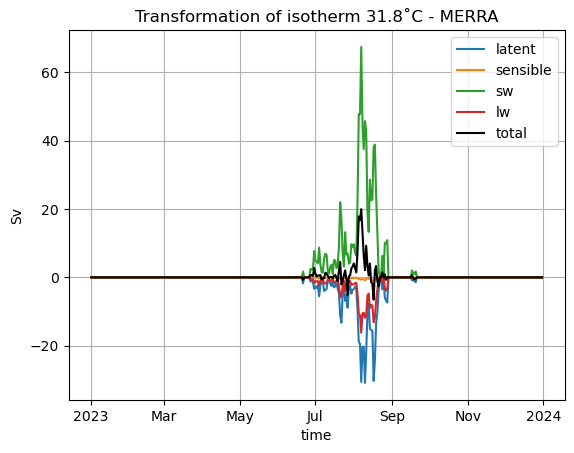

In [50]:
years = dict(time=slice('2023', '2023'))
(one_plt_merra.omega_EFLUXWTR/1e6).sel(**years).plot(label='latent')
(one_plt_merra.omega_HFLUXWTR/1e6).sel(**years).plot(label='sensible')
(one_plt_merra.omega_SWGNTWTR/1e6).sel(**years).plot(label='sw')
(one_plt_merra.omega_LWGNTWTR/1e6).sel(**years).plot(label='lw')
(one_plt_merra/1e6).sel(**years).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.ylabel('Sv')
#plt.ylim(-10,10)
plt.grid()
plt.title('Transformation of isotherm 31.8˚C - MERRA');

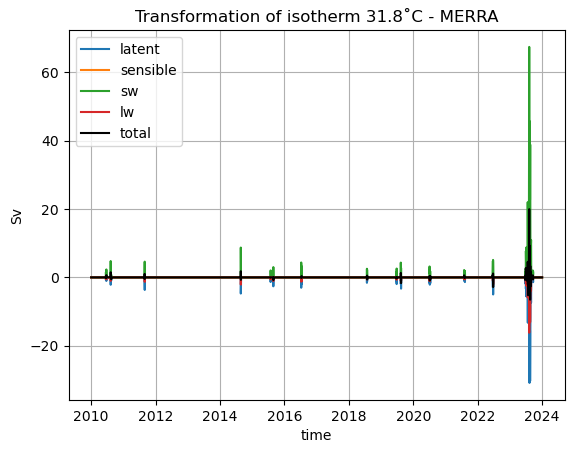

In [29]:
(one_plt_merra.omega_EFLUXWTR/1e6).plot(label='latent')
(one_plt_merra.omega_HFLUXWTR/1e6).plot(label='sensible')
(one_plt_merra.omega_SWGNTWTR/1e6).plot(label='sw')
(one_plt_merra.omega_LWGNTWTR/1e6).plot(label='lw')
(one_plt_merra/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.ylabel('Sv')
#plt.ylim(-10,10)
plt.grid()
plt.title('Transformation of isotherm 31.8˚C - MERRA');

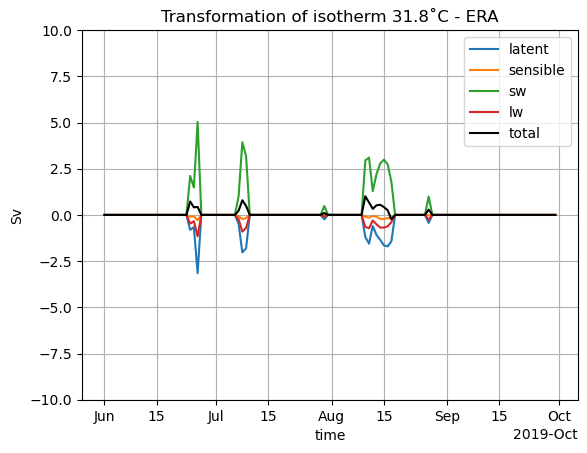

In [101]:
years = dict(time=slice('2019-06', '2019-09'))
(one_plt_era.omega_slhf/1e6).sel(**years).plot(label='latent')
(one_plt_era.omega_sshf/1e6).sel(**years).plot(label='sensible')
(one_plt_era.omega_ssr/1e6).sel(**years).plot(label='sw')
(one_plt_era.omega_str/1e6).sel(**years).plot(label='lw')
(one_plt_era/1e6).sel(**years).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.ylabel('Sv')
plt.ylim(-10,10)
plt.grid()
plt.title('Transformation of isotherm 31.8˚C - ERA');

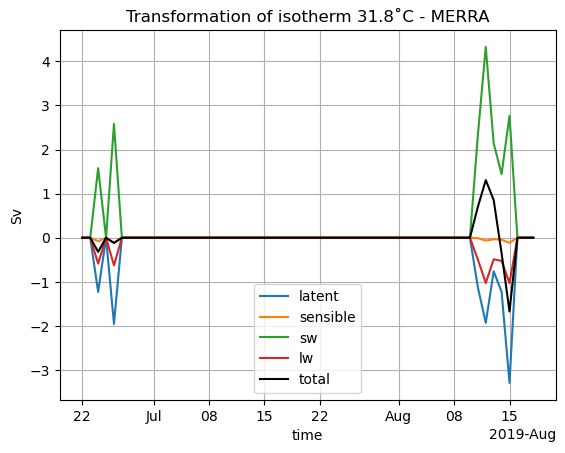

In [102]:
years = dict(time=slice('2019-06-22', '2019-08-18'))
(one_plt_merra.omega_EFLUXWTR/1e6).sel(**years).plot(label='latent')
(one_plt_merra.omega_HFLUXWTR/1e6).sel(**years).plot(label='sensible')
(one_plt_merra.omega_SWGNTWTR/1e6).sel(**years).plot(label='sw')
(one_plt_merra.omega_LWGNTWTR/1e6).sel(**years).plot(label='lw')
(one_plt_merra/1e6).sel(**years).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.ylabel('Sv')
#plt.ylim(-10,10)
plt.grid()
plt.title('Transformation of isotherm 31.8˚C - MERRA');

## Make tranformation movies!

In [49]:
from xmovie import Movie
%matplotlib inline

In [50]:
def plot_sw(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    transformation = (da/1e6).isel(time=tt).plot(ax=ax)
    plt.grid()
    plt.ylim(0, 150)
    plt.xlim(20,36);
    
    return ax, transformation

(<Axes: title={'center': 'time = 2010-04-11'}, xlabel='theta_bin', ylabel='omega_SWGNTWTR'>,
 [<matplotlib.lines.Line2D at 0x7e35f42ccd10>])

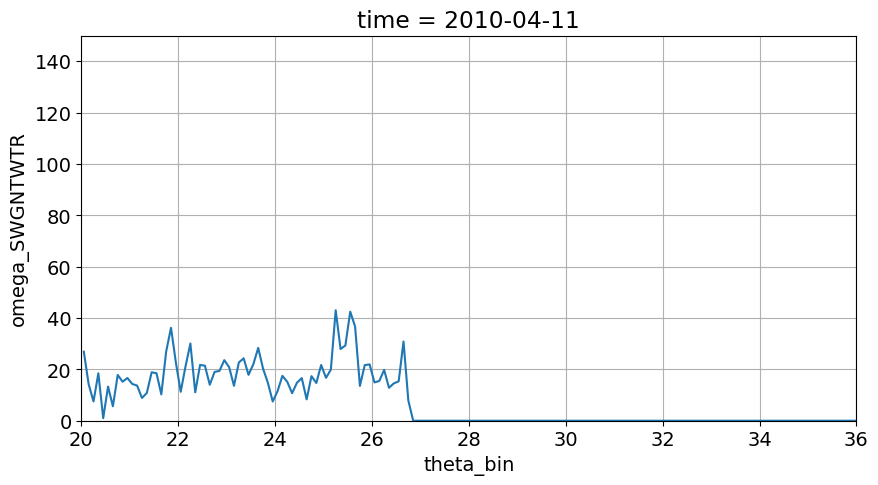

In [51]:
fig = plt.figure(figsize= (10, 5))
plot_sw(merra_hist.omega_SWGNTWTR, fig, 100)

In [52]:
sw_m = Movie(merra_hist.omega_SWGNTWTR.chunk({'time':1}), plot_sw, input_check=False)
sw_e = Movie(era_hist.omega_ssr.chunk({'time':1}), plot_sw, input_check=False)

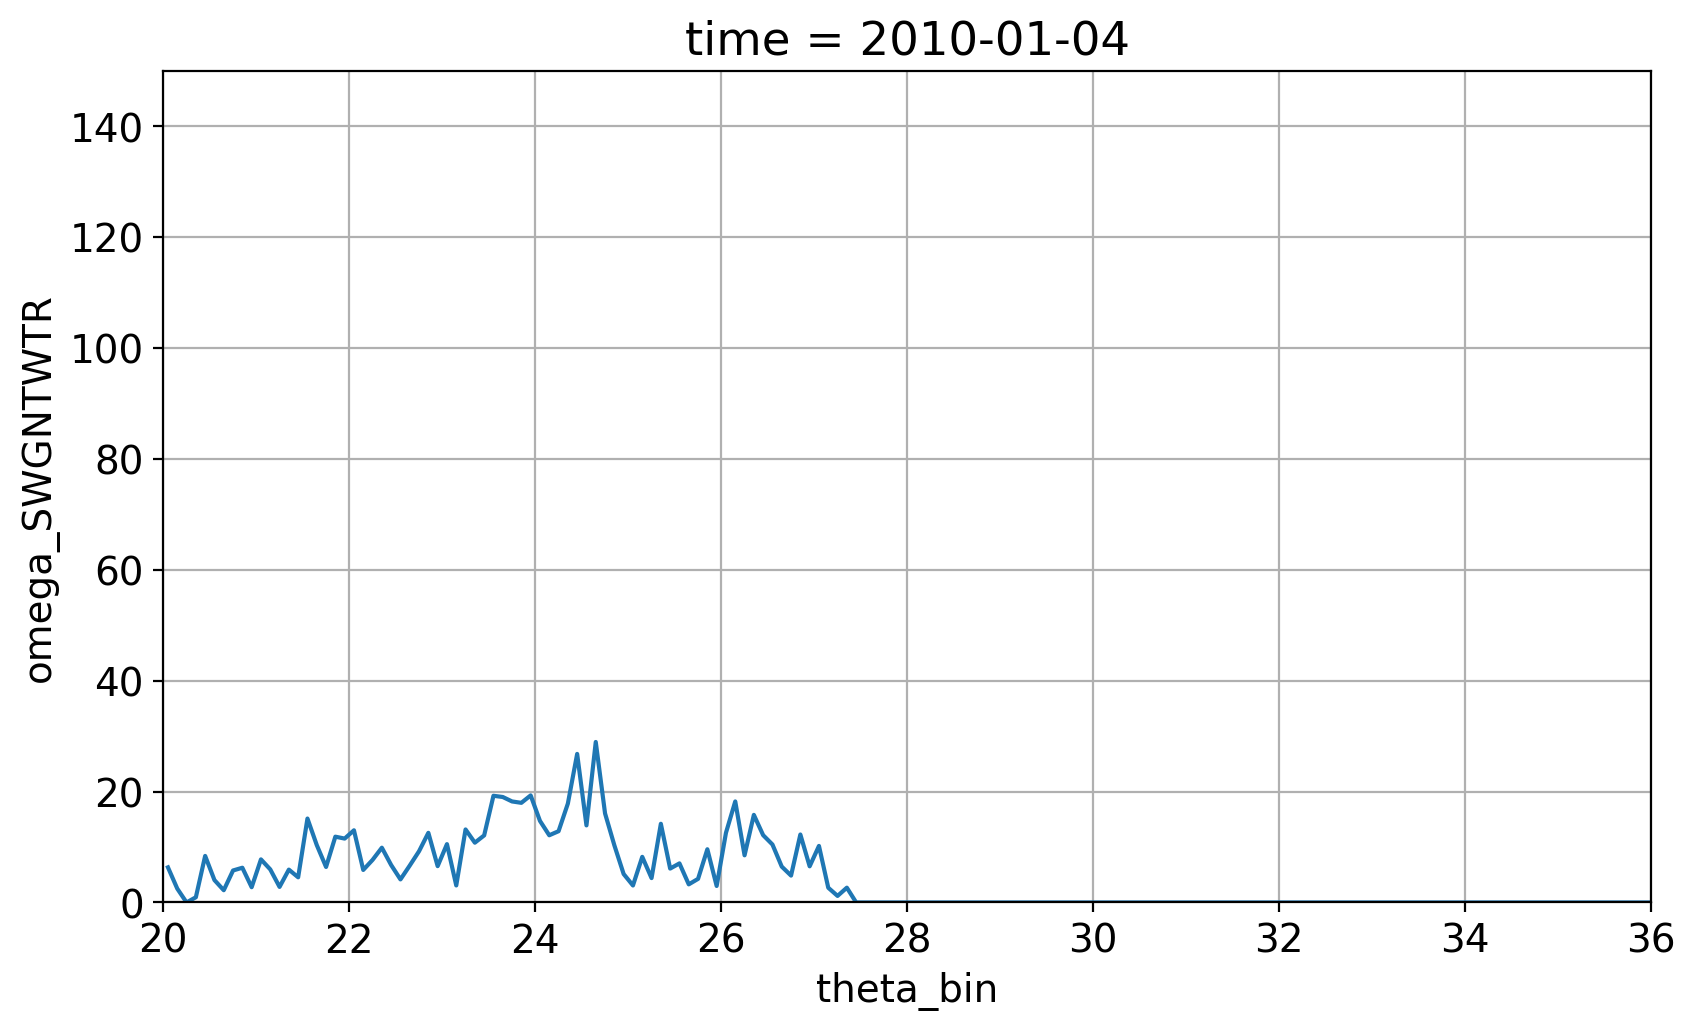

In [53]:
sw_m.preview(3)

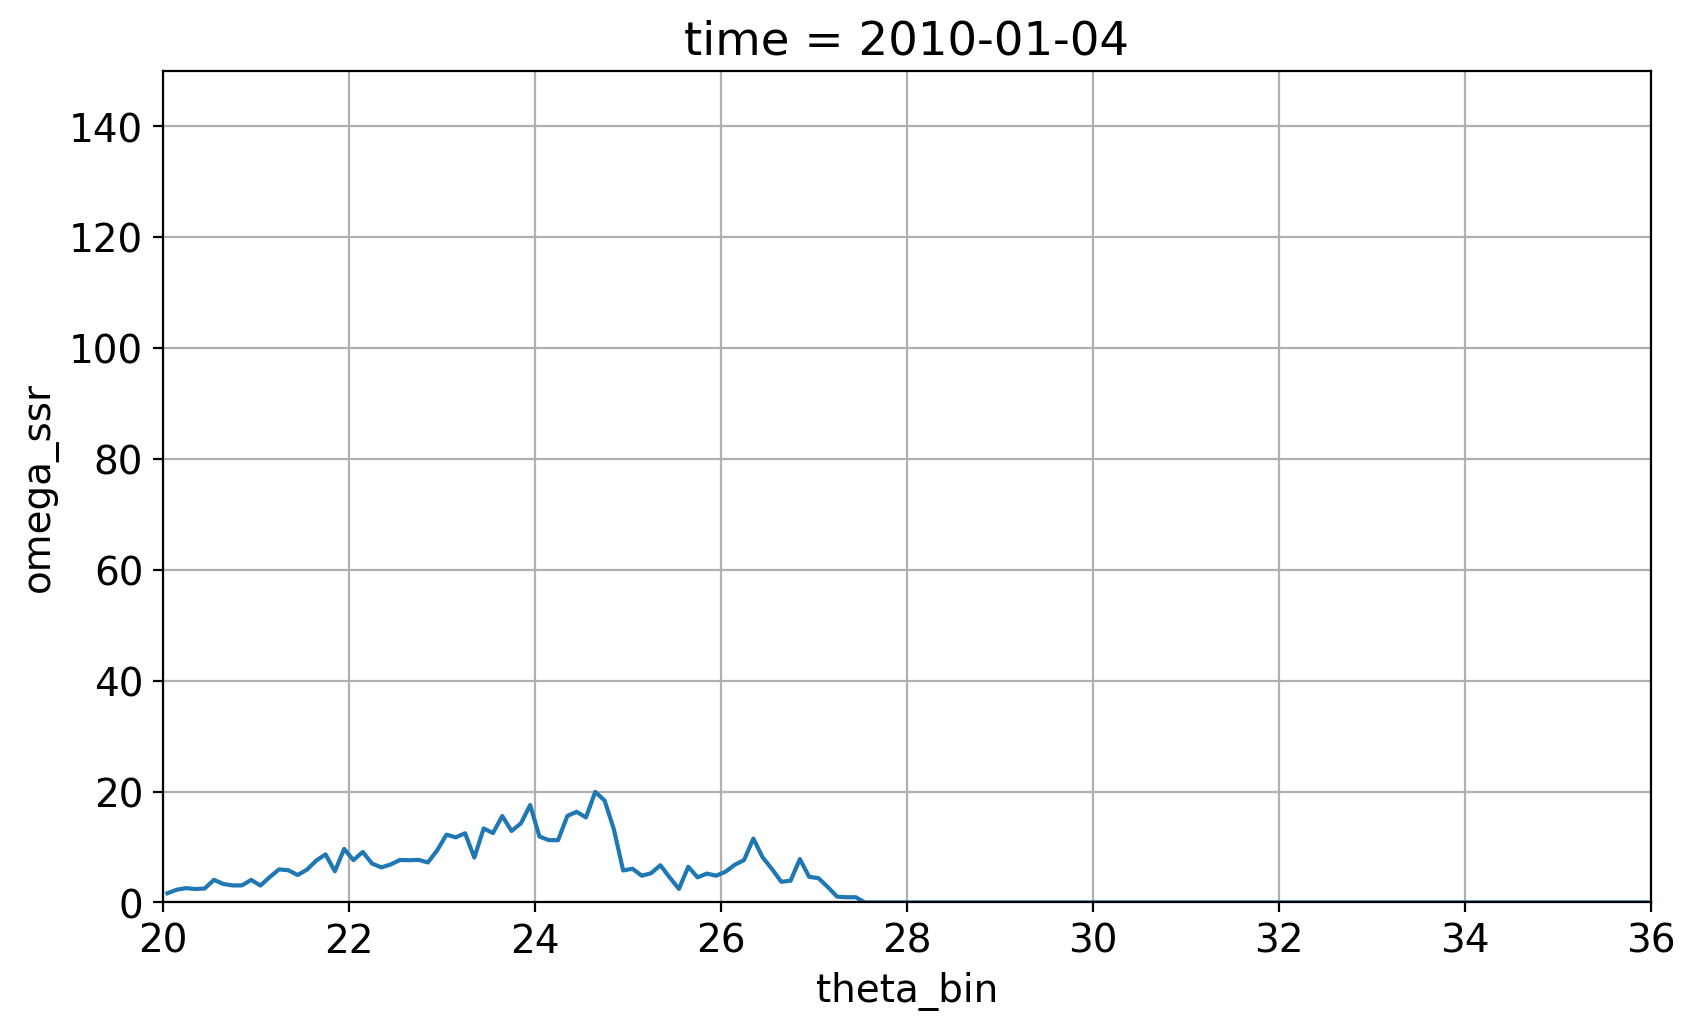

In [54]:
sw_e.preview(3)

In [65]:
sw_m.save('sw_m.mp4', parallel=True, overwrite_existing=True, progress=True,
         parallel_compute_kwargs=dict(scheduler="processes", num_workers=8))

Movie created at sw_m.mp4


In [67]:
sw_e.save('sw_e.mp4', parallel=True, overwrite_existing=True, progress=True,
         parallel_compute_kwargs=dict(scheduler="processes", num_workers=8))

Movie created at sw_e.mp4


# Save histograms

In [40]:
#uploading histograms
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/hist_ds_updated.zarr')
era_hist.to_zarr(gcsmap_ds, mode='w')

In [41]:
gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/hist_ds_updated.zarr')
merra_hist.to_zarr(gcsmap_ds, mode='w')